In [1]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
# import seaborn as sns
import warnings
# warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 80
# plt.rcParams['axes.grid'] = True
# sns.set()


In [2]:
import sys
sys.path.insert(0, '..')
from synthesizer import Synthesizer
from generator import Generator
from algorithm import Algorithm


from hypers import weight_hypers
from hypers import alpha_hypers

In [3]:
series_type = "arima"
from_start = True
a, b = -40, 40
train_window = 10

# Cоздание синтезатора, cпособного создавать workers_num наборов параметров, для каждого из которых генерировать временные ряды.
# Сигнал - случайный вектор из нормального распределения. Отклик - скалярное произведение сигнала на вектор весов плюс нормальный шум из N(0,1)
synt = Synthesizer(series_type, dim=10, low=-10, high=10, clip=(a, b),
                   noise_var=1, workers_num=3, random_seed=111)

# Создание генератора данных, склеивающего разнородные временные ряды в один 
# В данном случае источник рядов - наш синтезатор
gen = Generator(series_type, synt)

# Получение итогового временного ряда путем получения от синтезатора pieces_num временных рядов 
# произвольного размера из [lower_bound, upper_bound) и их последующей склейки
gen.generate(length=2000, from_start=from_start, lower_bound=100, upper_bound=400, alternating=True)


In [4]:
# gen.show_time_series()

In [5]:
# gen.draw_merged()

In [6]:
gen.launch()
algo0 = Algorithm("default", gen, train_window=train_window, a=a, b=b)
algo0.run()
algo0.post_calculations(from_start=from_start)

gen.launch()
algo1 = Algorithm("arima", gen, train_window=train_window, a=a, b=b)
algo1.run()
algo1.post_calculations(from_start=from_start)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.39it/s]


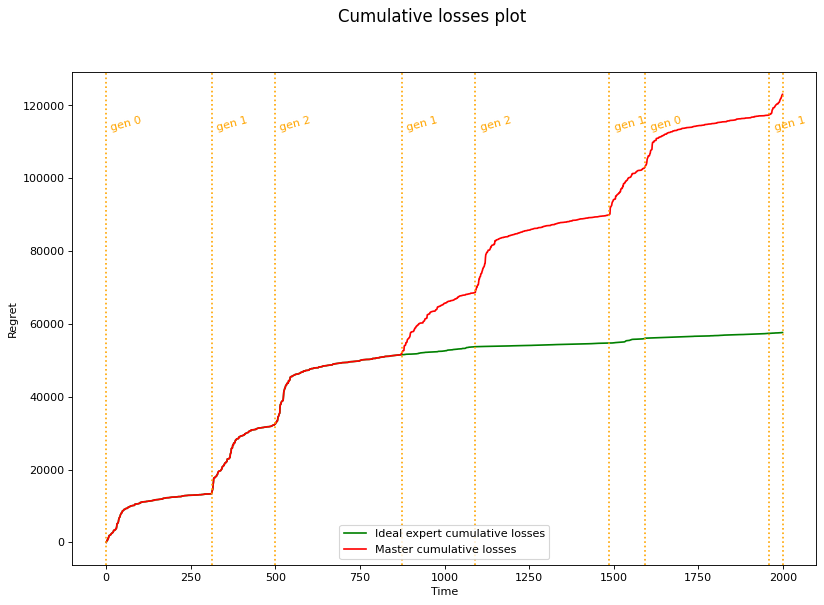

In [7]:
algo0.draw_all(show=["master", "ideal"], show_experts=[], show_axes=["regret"], height_ratios=[1], 
                  suptitle=f"Cumulative losses plot", fig_size=(12, 8))

In [8]:
algo1.stamps

array([   0,  312,  498,  873, 1091, 1487, 1594, 1960, 2000])

In [9]:
algo1.best_combo

array([   1,  312,  498,  332,  677, 1037,  116, 1502])

In [10]:
algo1.master_predictions_all[:7]

array([  0.        ,   7.22038876,  -2.12881554,   4.80192853,
        -3.22638262,   6.08278347, -10.28600661])

In [11]:
algo1.experts[362].arima_terms[-200:]

[-28.733502051206735,
 -28.409877741916436,
 -6.551011094316609,
 -0.29181022248441213,
 -0.9470369174683089,
 -15.673799475810426,
 -6.077843235942387,
 22.865427673610398,
 -5.736170976531949,
 10.912318970907437,
 5.69501240204986,
 3.801823339716755,
 3.053716107506419,
 2.723914027895394,
 -11.17536916113269,
 -13.9537217729593,
 0.765183149428279,
 26.990158565292656,
 8.268693363059764,
 -30.04018089307392,
 -23.580058469699033,
 6.048339169435296,
 16.748733182781482,
 16.947815590206467,
 -13.747251418911992,
 -17.251127557778798,
 4.8794615373050565,
 22.20952971338381,
 -6.746134415912341,
 -6.15723303202442,
 -9.106344972153611,
 1.7948523058224706,
 1.045597456038863,
 -12.971670926642123,
 -14.010251886605605,
 25.1329249290994,
 36.26834825588703,
 13.305111954674885,
 1.4424426134679873,
 -3.664716354031959,
 15.701505775163593,
 5.572928120487143,
 -12.88804457908737,
 -12.937817922495796,
 34.28172541653933,
 16.182112889430005,
 -11.281582253245382,
 -4.8578097555715

In [12]:
algo1.experts_predictions_all.T[400]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -1.00000003e+09,  9.99999993e+08, -9.99999982e+08])

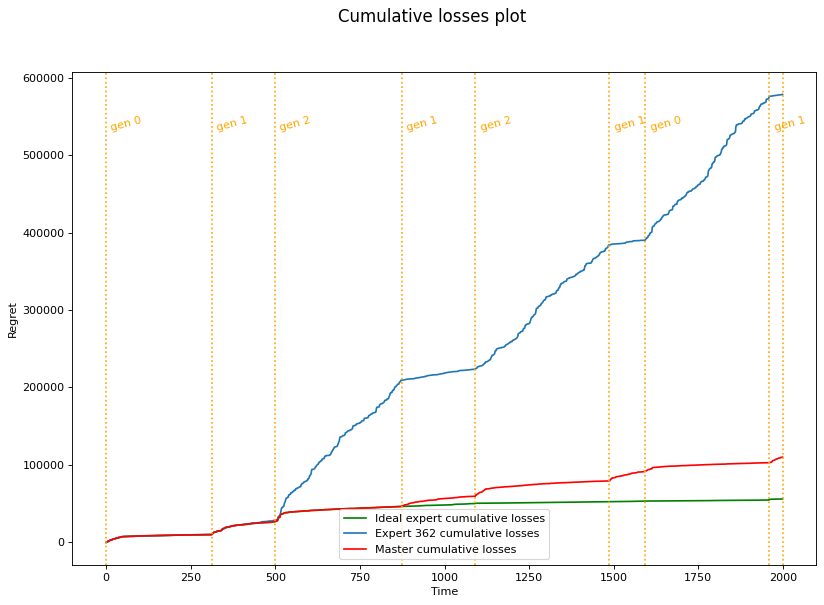

In [13]:
algo1.draw_all(show=["master", "ideal"], show_experts=[362], show_axes=["regret"], height_ratios=[1], 
                  suptitle=f"Cumulative losses plot", fig_size=(12, 8))

In [14]:
algo0.master_losses_all[-4:]

array([1.65185389e+02, 4.06958362e+02, 1.97499481e-02, 3.04120785e+02])

In [15]:
algo1.master_losses_all[-4:]

array([ 44.95461387, 139.9550843 ,   0.19754839, 167.73217741])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


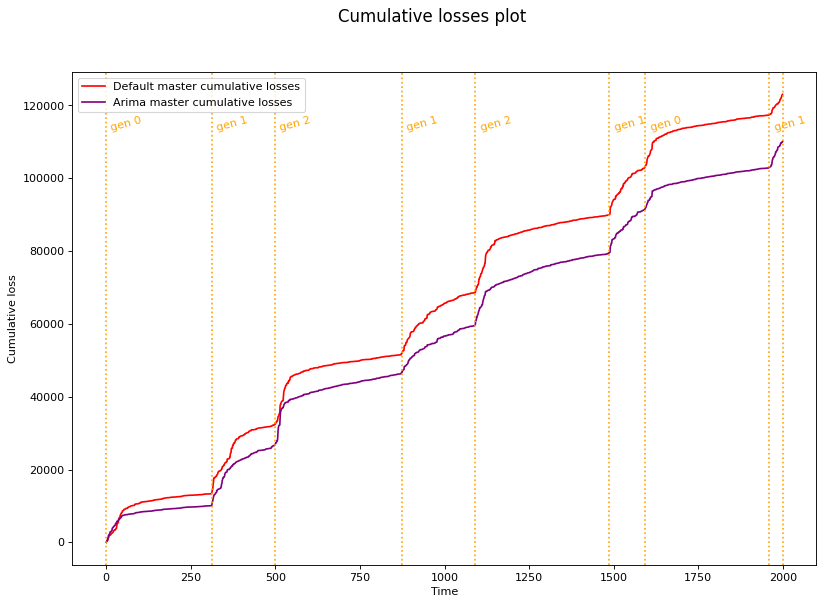

In [19]:
draw_more(algo0, show=["master"], show_experts=[], show_axes=["regret"], height_ratios=[1], 
                  suptitle=f"Cumulative losses plot", fig_size=(12, 8), other=[algo1.master_losses_all], labels=["Arima master cumulative losses"], colors=["purple"])

In [ ]:
algo1.experts_predictions_all.T[901][900:1040]

In [ ]:
gen.params_list[0]

In [ ]:
algo0.experts[895].coef_

In [17]:
def draw_more(logs, show=None, show_experts=None,
             show_axes=None, height_ratios=None, suptitle=None, fig_size=(15, 10), other=None, labels=None, colors=None, loc='upper left'):

    if show is None:
        show = ["master"]
    if show_experts is None:
        show_experts = []
    if show_axes is None:
        show_axes = ["regret"]
    if height_ratios is None:
        height_ratios = [1 for _ in show_axes]
    if suptitle is None:
        suptitle = "Algorithm"
    assert len(show_axes) == len(height_ratios), "Wrong sizes"
    if other is None:
        other = []
        labels = []
        colors=[]
    

    text_idx = 0

    fig, axes = plt.subplots(len(show_axes), 1, figsize=fig_size, sharex=True, height_ratios=height_ratios)
    ax = [axes] if len(show_axes) == 1 else axes
    grid = np.arange(logs.total_time - logs.shift)

    try:
        idx = show_axes.index("loss")
        text_idx = idx

        if "ideal" in show:
            ax[idx].plot(grid, logs.ideal_losses[logs.shift:], label="Ideal expert losses",
                         color='green')
        if "zero" in show:
            ax[idx].plot(grid, logs.zero_losses[logs.shift:],
                         label="Zero expert losses",
                         color='yellow')
        for expert_num in show_experts:
            ax[idx].plot(grid, logs.experts_losses_all.T[expert_num][logs.shift:],
                         label=f"Expert {expert_num} losses")
        if "master" in show:
            ax[idx].plot(grid, logs.master_losses_all[logs.shift:], label="Master losses",
                         color='red')

        ax[idx].set_ylabel("Loss")
        ax[idx].legend()

    except ValueError:
        pass

    try:
        idx = show_axes.index("regret")

        if "ideal" in show:
            ax[idx].plot(grid, logs.ideal_losses[logs.shift:].cumsum(),
                         label="Ideal expert cumulative losses", color='green')
        if "zero" in show:
            ax[idx].plot(grid, logs.zero_losses[logs.shift:].cumsum(),
                         label="Zero expert cumulative losses", color='yellow')

        for expert_num in show_experts:
            ax[idx].plot(grid, logs.experts_losses_all.T[expert_num][logs.shift:].cumsum(),
                         label=f"Expert {expert_num} cumulative losses")

        if "master" in show:
            ax[idx].plot(grid, logs.master_losses_all[logs.shift:].cumsum(),
                         label="Default master cumulative losses", color='red')

        if "theoretical" in show:
            ax[idx].plot(grid, logs.theoretical_upper[logs.shift:],
                         label="Theoretical upper bound", color='black')
        for another, label, color in zip(other, labels, colors):
            ax[idx].plot(grid, another[logs.shift:].cumsum(),
                             label=label, color=color)
        

        ax[idx].set_xlabel("Time")
        ax[idx].set_ylabel("Cumulative loss")
        ax[idx].legend(loc=loc)

    except ValueError:
        pass

    bottom, top = ax[text_idx].get_ybound()
    left, right = ax[text_idx].get_xbound()
    for gen_idx, gen_stamp in zip(np.r_[logs.indexes, -1], logs.stamps):
        if gen_stamp < logs.shift:
            continue
        for i in range(len(show_axes)):
            ax[i].axvline(gen_stamp - logs.shift, color='orange', linestyle=':')
        if gen_idx != -1:
            ax[text_idx].text(x=gen_stamp - logs.shift + 0.005 * (right - left), y=top - 0.12 * (top - bottom),
                              s=f"gen {gen_idx}", color='orange', rotation=15)

    fig.suptitle(suptitle, fontsize=15)
    # plt.savefig('../results/impovement.png')
    plt.savefig('../results/improvement3.eps', format='eps')
    plt.show()
   